## Scenario: Velocity heat/vector map in Little Egg Inlet, NJ

#### Get a dataset (In this case, ROMS) that covers the area

In [1]:
from netCDF4 import Dataset
import numpy as np
import pysgrid

url = ('http://geoport-dev.whoi.edu/thredds/dodsC/clay/usgs/users/zdefne/run076/his/00_dir_roms_display.ncml')

nc = Dataset(url)
sgrid = pysgrid.load_grid(nc)
sgrid  # We need a better __repr__ and __str__ !!!

#### Generate a mesh grid of points within the lat/lon bounds

In [2]:
%%time
lons, lats = np.mgrid[-74.38:-74.26:600j, 39.45:39.56:600j]

points = np.stack((lons, lats), axis = -1)
                
print points.shape


(600L, 600L, 2L)
Wall time: 12 ms


#### After determining the time, depth, and points you are interested in, just interpolate!

In [3]:
%%time
time_idx = 0
depth_idx = -1

interp_u = sgrid.interpolate_var_to_points(points, sgrid.u, slices=[time_idx, depth_idx])
interp_v = sgrid.interpolate_var_to_points(points, sgrid.v, slices=[time_idx, depth_idx])

#other function signatures:
interp_u2 = sgrid.interpolate_var_to_points(points, sgrid.u[time_idx, depth_idx])
interp_u3 = sgrid.interpolate_var_to_points(points, nc.variables['u'], slices=[time_idx, depth_idx])
print np.all(interp_u == interp_u2)
print np.all(interp_u == interp_u3)

True
True
Wall time: 57.3 s


In [4]:
#rotation is still ugly...
from pysgrid.processing_2d import rotate_vectors, vector_sum
from pysgrid.processing_2d import vector_sum

ind = sgrid.locate_faces(points)
ang_ind = ind + [1, 1]
angles = sgrid.angles[:][ang_ind[:, 0], ang_ind[:, 1]]
u_rot, v_rot = rotate_vectors(interp_u, interp_v, angles)
u_rot = u_rot.reshape(600,-1) # reshape for pcolormesh
v_rot = v_rot.reshape(600,-1)

uv_vector_sum = vector_sum(u_rot, v_rot)

c:\users\jay.hennen\documents\code\pysgrid\pysgrid\processing_2d.py:25: RuntimeWarning: invalid value encountered in sqrt
  vector_sum = np.sqrt(x_arr**2 + y_arr**2)


In [5]:
%matplotlib inline

#Credit to Filipe for the plotting cells below

import numpy as np
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree(), figsize=(12, 12)):
    fig, ax = plt.subplots(figsize=figsize,
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

C:\Users\Jay.Hennen\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


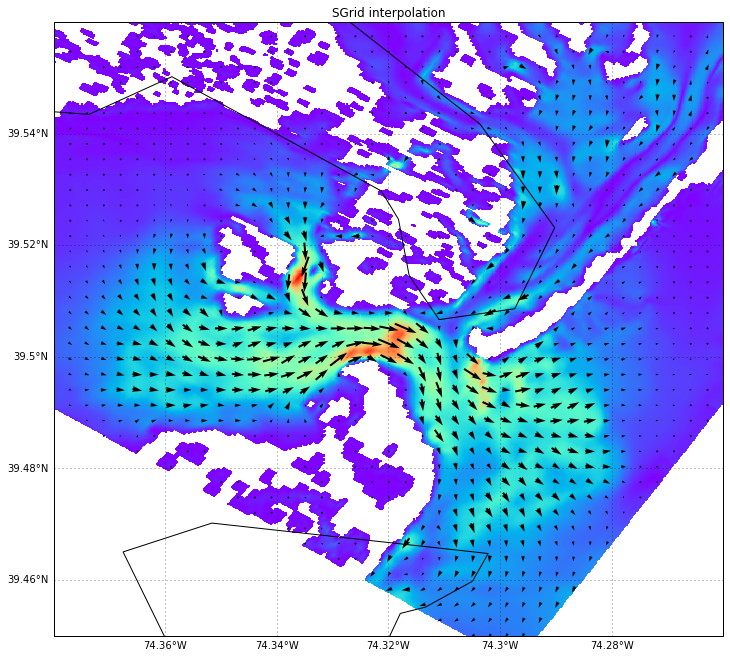

In [6]:
mscale = 1
vscale = 15
scale = 0.04
lon_data = lons
lat_data = lats

fig, ax = make_map()

kw = dict(scale=1.0/scale, pivot='middle', width=0.003, color='black')
q = plt.quiver(lon_data[::vscale, ::vscale], lat_data[::vscale, ::vscale],
               u_rot[::vscale, ::vscale], v_rot[::vscale, ::vscale], zorder=2, **kw)

cs = plt.pcolormesh(lon_data[::mscale, ::mscale],
                    lat_data[::mscale, ::mscale],
                    uv_vector_sum[::mscale, ::mscale], zorder=1, cmap=plt.cm.rainbow)
ax.coastlines('10m');
plt.title('SGrid interpolation')
plt.show()

